![](../images/rivacon_frontmark_combined_header.png)

# Introduction to Discount Certificates

In [1]:
import datetime as dt
import math
import matplotlib.pyplot as plt
from scipy.stats import norm
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import random
import pandas as pd
import numpy as np
import rivapy
from rivapy import enums as enums
from rivapy import marketdata as mkt_data


%load_ext autoreload
%autoreload 2
#the next line is a jupyter internal command to show the matplotlib graphs within the notebook
%matplotlib inline

## Definition of a Discount Certificate

[Deutsche Börse](https://www.boerse-frankfurt.de/en/know-how/glossary/discount-certificates) provides the following definition for the discount certificate:

    **Certificate with a reduced entry price in return for a limited payout.**
    The investor gets the certificate at a price that is below the current price of the underlying security or index. This is called a discount. In return, the potential profit is capped.

    At the end of the certificate’s maturity, a cash check occurs: If the price of the underlying when the maturity is up is higher than the maximal payout or identical to it, the issuer pays the maximum amount.

    If the price of the underlying is less than the cap, the issuer pays either the current price of the certificate in cash or he gives the investor the underlying, for example a share, at its current price. The issuer can choose. The cash payout is obligatory in the case of discount certificates on indices, currencies or interest.

    The maximum profit that an investor can reach with a discount certificate is calculated by taking the difference between the purchase price and the cap on the underlying. Losses, in contrast, are lessened by the discount. The investor suffers a loss only when the price of the underlying at the end of the maturity has fallen so far that the discount is depleted. The discount thus works as a buffer against risk.

    Discount certificates are ideal for conservative investors that want to guard against market fluctuations and who expect in the medium term sideways-moving prices. Because the buyer of a discount certificate does not profit from price gains that are higher than the cap, this form of investment is best suited for a medium-term oriented engagement. If the certificate reaches its cap before the maturity, the investor should take the profits.

## Construction of a Discount Certificate

A discount certificate is constructed by combining a long zero-strike-call (or security less discounted dividends) and a short call with a strike price equal to the cap. While the price for the long zero-strike-call increases with the price of the underlying security or index, gains beyond the cap are compensated by the short call.

The relative size of the discount primarily depends on the volatility of the underlying and the time-to-maturity. Since the option premium of the short call increases with higher volatility, a higher discount can be offered to the investor. Likewise, longer maturities influence the discount positively.

The absolute size of the discount is mainly determined by the position of the cap in relation to the current underlying price. If the cap and the current price of the underlying are on a similar level, the short call premium is higher (since it is at the money) and hence, the discount is higher. If the cap is higher than the current price of the underlying (i.e. the short call is out of the money), a smaller discount can be offered to the investor.

**Example**

The current price of the underlying is $S_0$ = 70, the cap at 77 and the short call pays an option premium of 5.

In [18]:
# 
S0 = 70
cap = 77
short_call_premium = 5
S_t = np.linspace(50, 90, 41)

pnl_dc =  [-S0 + short_call_premium + np.min([s, cap]) for s in S_t]
payoff_short_call = [short_call_premium - np.max([s - cap, 0]) for s in S_t]

fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add traces
fig.add_trace(go.Scatter(x=S_t,y=S_t,mode='lines',name='Payoff Zero-Strike-Call',visible = "legendonly"),secondary_y=True)
fig.add_trace(go.Scatter(x=S_t,y=[S0 - short_call_premium + dc_pnl for dc_pnl in pnl_dc],mode='markers',name='Payoff Certificate',visible = "legendonly"),secondary_y=True)

fig.add_trace(go.Scatter(x=S_t,y=S_t - S0,mode='lines',name='PnL Zero-Strike-Call',visible = True))
fig.add_trace(go.Scatter(x=S_t,y=pnl_dc,mode='markers',name='PnL Discount Certificate',visible = "legendonly"))
fig.add_trace(go.Scatter(x=S_t,y=payoff_short_call,mode='lines+markers',name='PnL Embedded Short Call',visible = "legendonly"))

fig.add_vline(x=S0, annotation_text='S0', line_dash='dash', line_color='black')
fig.add_vline(x=cap,annotation_text='Cap',line_dash='dash',line_color='black')

# Add figure title
fig.update_layout(title_text='Discount Certificate')

# Set x-axis title
fig.update_xaxes(title_text='Underlying at Maturity')

# Set y-axis titles
fig.update_yaxes(title_text='PnL', secondary_y=False)
fig.update_yaxes(title_text='Payoff', secondary_y=True)

fig.show()

---

## Pricing a Discount Certificate

In [25]:
# define option pricer
def B76OptionPricer(Type,F, K, r_dsc, sigma, T, t=0):
    d1 = (math.log(F/K)+(sigma**2/2)*(T-t))/(sigma*math.sqrt(T-t))
    d2 = d1-sigma*math.sqrt(T-t)
    if Type=='c':
        cp = 1
    if Type =='p':
        cp = -1
    return cp*math.exp(-r_dsc*(T-t))*(F*norm.cdf(cp*d1)-K*norm.cdf(cp*d2))

# Definition of the input parameters
K = cap # 50 # Strike price
r_dsc = 0.0 # Discount rate
r_f = 0.0 # Funding rate
r_b = 0.0 # Borrowing rate
sigma = 0.30 # Volatility of the underlying
t = 0.0 # Time to valuation date
T = 1.0 # Time to maturity
F0 = S0*math.exp((r_f-r_b)*(T-t)) # Forward value is calculated assuming a funding-rate different from the discount rate minus the borrowing rate

# Calculation of the call price
c = B76OptionPricer('c', F0, K, r_dsc, sigma, T, t)
print('Call price = ', c)

# #Calculation of the put price
# p = B76OptionPricer('p', F0, K, r_dsc, sigma, T, t)
# print('Put price = ', p)

Call price =  3.4578261574740665


In [7]:
# Prototype for pricing a discount certificate

class DiscountCertificatePricingData:
    def __init__(self,
                 val_date: dt,
                 spec,
                 discount_curve,
                 vol_surface,
                 pricing_request
                 ):   
        self.val_date = val_date
        self.spec = spec
        self.discount_curve = discount_curve
        self.vol_surface = vol_surface
        self.pricing_request = pricing_request
        self.embedded_spec = rivapy.instruments.EuropeanVanillaSpecification(
            id='embeddedOption', type='CALL',
            expiry = self.spec.expiry,
            strike = self.spec.cap,
            issuer = '',
            sec_lvl = 'COLLATERALIZED',
            curr = 'EUR',
            udl_id = '',
            share_ratio = 1.0)
        
def DiscountCertificatePricer(prdata):
    embeddedOption_PricingData = rivapy.pricing.Black76PricingData(val_date = prdata.val_date, 
                                                                    spec = prdata.embedded_spec, 
                                                                    discount_curve = prdata.discount_curve, 
                                                                    vol_surface = prdata.vol_surface,
                                                                    pricing_request=prdata.pricing_request)
    embeddedOptionPrice = rivapy.pricing.price(embeddedOption_PricingData).getPrice()
    return prdata.vol_surface.forward_curve.spot - embeddedOptionPrice
    
class DiscountCertificateSpecification:
    def __init__(self, 
                 id: str,
                 expiry: dt,
                 cap: float,
                ):
        """Constructor for discount certificates
        Args:
        """
        self.id = id
        self.expiry = expiry
        self.cap = cap

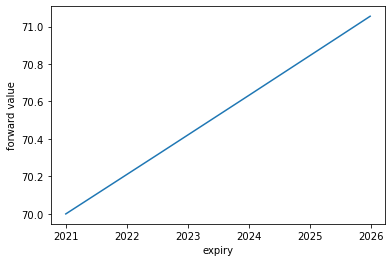

In [8]:
# Example 

refdate = dt.datetime(2021,1,1,0,0,0)
days_to_maturity = [1, 180, 365, 720, 3*365, 4*365, 10*365]
dates = [refdate + dt.timedelta(days=d) for d in days_to_maturity]
# discount factors from constant rate
disc_rate = 0.005
dc = rivapy.marketdata.DiscountCurve("DC", refdate, dates, 
                                            [math.exp(-d/365.0*disc_rate) for d in days_to_maturity])
borrow_rate = 0.002
bc = rivapy.marketdata.DiscountCurve("BC", refdate, dates, 
                                            [math.exp(-d/365.0*borrow_rate) for d in days_to_maturity])

funding_rate = 0.005
fc = rivapy.marketdata.DiscountCurve("FC", refdate, dates, 
                                            [math.exp(-d/365.0*funding_rate) for d in days_to_maturity])

ex_dates =  [refdate + dt.timedelta(days=i) for i in [365, 2*365, 3*365, 4*365]]
pay_dates = [d + dt.timedelta(days=2) for d in ex_dates]
tax_factors = [1.0, 1.0, 1.0, 1.0]
div_yield = [0, 0.0, 0.0, 0.0]
div_cash = [0, 0, 0, 0]
div_table = rivapy.marketdata.DividendTable('DIV', refdate, ex_dates, pay_dates, div_yield, div_cash, tax_factors)


spot = 70.0
forward_curve = rivapy.marketdata.EquityForwardCurve(spot, fc, bc, div_table)
forward_curve.plot(days_end=5*365)

# vol surfaces
# flat
vol_param_flat = rivapy.marketdata.VolatilityParametrizationFlat(0.3)

# term
ttm = [0.07,0.19,0.69,0.94,1.19,1.69]
fwd_atm_vols =  [0.25,0.24,0.22, 0.21, 0.20, 0.19]
term_param = mkt_data.VolatilityParametrizationTerm(ttm,fwd_atm_vols)

# ssvi
rho = -0.7 # responsible for the skewness of the vol_surface
eta = 0.7 # responsible for the curvature
gamma = 0.6 # responsible for the "rate of decay"
ssvi_param = mkt_data.VolatilityParametrizationSSVI(ttm, fwd_atm_vols, rho, eta, gamma)

# svi
svi_param = mkt_data.VolatilityParametrizationSVI(
                expiries=np.array([0.07,0.19,0.69,0.94,1.19,1.69]), 
                svi_params=[
                            (0.01, 0.08, -0.42, 0.07, 0.05),
                            (0.01, 0.09, -0.52, 0.08, 0.05),
                            (0.01, 0.09, -0.72, 0.09, 0.09),
                            (0.02, 0.08, -0.91, 0.10, 0.07),
                            (0.01, 0.12, -0.70, 0.11, 0.19),
                            (0.03, 0.09, -1.02, 0.13, 0.15)
])

# sabr
ttm = [0.07,0.19,0.69,0.94,1.19,1.69]
sabr_params = np.array([[0.05, 0.90, 0.32, -0.82],
                        [0.08, 0.01, 1.22, -0.49],
                        [0.15, 0.20, 0.12, -0.79],
                        [0.18, 0.84, 0.58, -0.72],
                        [0.20, 0.62, 0.09, -0.58],
                        [0.20, 0.62, 0.09, -0.58]])

vol_surf_flat = rivapy.marketdata.VolatilitySurface('TEST_SURFACE', refdate, forward_curve, enums.DayCounterType.Act365Fixed, vol_param_flat)
vol_surf_term = rivapy.marketdata.VolatilitySurface('TEST_SURFACE', refdate, forward_curve, enums.DayCounterType.Act365Fixed, term_param)
vol_surf_ssvi = rivapy.marketdata.VolatilitySurface('TEST_SURFACE', refdate, forward_curve, enums.DayCounterType.Act365Fixed, ssvi_param)
vol_surf_svi = rivapy.marketdata.VolatilitySurface('TEST_SURFACE', refdate, forward_curve, enums.DayCounterType.Act365Fixed, svi_param)
vol_surf_sabr = rivapy.marketdata.VolatilitySurface('TEST_SURFACE', refdate, forward_curve, enums.DayCounterType.Act365Fixed, sabr_params)

In [9]:
myCert_spec = DiscountCertificateSpecification('test_id', dt.datetime(2022,12,31), 77)


prdata_flat = DiscountCertificatePricingData(val_date = refdate, 
                                           spec = myCert_spec, 
                                           discount_curve = dc, 
                                           vol_surface = vol_surf_flat, 
                                           pricing_request=(rivapy.pricing.ResultType.DELTA, 
                                                            rivapy.pricing.ResultType.GAMMA))

prdata_term = DiscountCertificatePricingData(val_date = refdate, 
                                           spec = myCert_spec, 
                                           discount_curve = dc, 
                                           vol_surface = vol_surf_term, 
                                           pricing_request=(rivapy.pricing.ResultType.DELTA, 
                                                            rivapy.pricing.ResultType.GAMMA))

prdata_ssvi = DiscountCertificatePricingData(val_date = refdate, 
                                           spec = myCert_spec, 
                                           discount_curve = dc, 
                                           vol_surface = vol_surf_ssvi, 
                                           pricing_request=(rivapy.pricing.ResultType.DELTA, 
                                                            rivapy.pricing.ResultType.GAMMA))

prdata_svi = DiscountCertificatePricingData(val_date = refdate, 
                                           spec = myCert_spec, 
                                           discount_curve = dc, 
                                           vol_surface = vol_surf_svi, 
                                           pricing_request=(rivapy.pricing.ResultType.DELTA, 
                                                            rivapy.pricing.ResultType.GAMMA))

# prdata_sabr = DiscountCertificatePricingData(val_date = refdate, 
#                                            spec = myCert_spec, 
#                                            discount_curve = dc, 
#                                            vol_surface = vol_surf_sabr, 
#                                            pricing_request=(rivapy.pricing.ResultType.DELTA, 
#                                                             rivapy.pricing.ResultType.GAMMA))
DiscountCertificatePricer(prdata_svi)

65.87954431361497

In [10]:
## surface plot:

fwd_spots = np.linspace(S0*0.8, S0*1.3, 101)
ttm = np.linspace(0.1, 1-1/365, 21)
# ttm[0] = 0.001
    
dc_prices = []
for i in range(len(fwd_spots)):
    scp_per_mat = []
    for j in range(len(ttm)):
        scp_per_mat.append(B76OptionPricer('c', fwd_spots[i], K, r_dsc, ssvi_param.calc_implied_vol(ttm[j],fwd_spots[i]/cap ), T, ttm[j]))
    dc_prices.append(fwd_spots[i]-scp_per_mat)


fig_surf = go.Figure(data=[go.Surface(x=T-ttm, y=fwd_spots,z=dc_prices
                        ,contours = {"x": {"show": True,"size": 0.1, "color":"red"},
                                    #"y": {"show": True,"size": 0.1, "color":"red"},
                                    }
                        ,opacity = .75
                        ,hovertemplate =
                        'Underlying:  %{y: .1f}' +
                        '<br>Maturity (yrs): %{x:.0}' +
                        '<br>Price: %{z:.1f}<extra></extra>'
                     ,colorscale = 'temps')
                     ])

fig_surf.update_layout(
    title={
        'text': "<b>Dicount Certificate price (Cap = 77)</b>",
        'y': 0.95,
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top'
    }
    # ,autosize=True
    ,
    width=1000,
    height=1000,
    scene=dict(xaxis_title='Time to Maturity (yrs)',
               xaxis_tickformat='.1f',
               # xaxis_autorange='reversed',
               yaxis_title='Underlying',
               yaxis_tickformat='.f', #'.2%'
               zaxis_title='Discount Certificate Price',
               zaxis_tickformat='.f'),
    font=dict(family="Courier New, monospace", size=10),
    margin=dict(l=65, r=50, b=65, t=90))

fig_surf.show()

---

# Discount Certificate Pro

https://derinet.vontobel.ch/api/kid?isin=DE000VP2ERZ4&language=de

In [26]:
premium_short_call = 3.5
premium_long_digital = -12.5
cap = 45
barrier = 29
strike_shortCall = barrier
S0 = 29
St = np.linspace(15, 50, 36)

pnl_short_call = [premium_short_call - np.max([S - strike_shortCall, 0]) for S in St]
pnl_digital = [premium_long_digital + 0 if S <= barrier else premium_long_digital + 2*12.5 for S in St]
PnL_DC =  St-S0 + pnl_short_call + pnl_digital
#         

fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add trades
fig.add_trace(go.Scatter(x=St,y=St,mode='lines',name='Payoff Underlying',visible = "legendonly"),secondary_y=True,)
fig.add_trace(go.Scatter(x=St,y=St + pnl_short_call + pnl_digital,mode='markers',name='Payoff Certificate Protect',visible = "legendonly"),secondary_y=True)

fig.add_trace(go.Scatter(x=St,y=St - S0,mode='lines',name='PnL Underlying'))
fig.add_trace(go.Scatter(x=St,y=PnL_DC,mode='markers',name='PnL Discount Certificate Protect',visible = "legendonly"))
fig.add_trace(go.Scatter(x=St,y=pnl_short_call,mode='lines+markers',name='PnL Embedded Short Call',visible = "legendonly"))
fig.add_trace(go.Scatter(x=St,y=pnl_digital,mode='lines+markers',name='PnL Embedded Digital Long Call',visible = "legendonly"))

fig.add_vline(x=S0,annotation_text='S0',line_dash='dash',line_color='black')
fig.add_vline(x=S0-premium_short_call-premium_long_digital,annotation_text='Kaufpreis DC',line_dash='dash',line_color='black')
#fig.add_hline(y=20,annotation_text='Cap',line_dash='dash',line_color='black')
fig.add_vline(x=barrier,annotation_text='Barrier',line_dash='dash',line_color='black')

# Add figure title
fig.update_layout(title_text='Discount Certificate Protect')

# Set x-axis title
fig.update_xaxes(title_text='Underlying at Maturity')

# Set y-axis titles
fig.update_yaxes(title_text='PnL', secondary_y=False)
fig.update_yaxes(title_text='Payoff', secondary_y=True)

fig.show()

## 38 DCP = Underlying (29)  - ShortCallPremium (5) + LongDigiPremium (14)
